In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import country_converter as coco
from matplotlib import pyplot as plt
from itertools import cycle, islice

In [2]:
EDITIONS = ["2000", "2001", "2002", "2003", "2004",
            "2005", "2006", "2007", "2008", "2009", 
            "2010", "2011", "2012", "2013", "2014",
            "2015", "2016", "2017", "2018", "2019",
            "2020", "2021", "2022", "2023", "2024"]

COLOR_LIST = ['darkblue', 'mediumblue', 'cornflowerblue', 
              'darkred', 'red', 'tomato', 'lightsalmon']

df = pd.read_csv("data/summary_dataset.csv")
print(df.shape)
print(df.columns)

(2483, 12)
Index(['Authors', 'Title', 'Year', 'Link', 'Abstract',
       'Authors with Affiliations', 'aff_names', 'Affiliation type',
       'Affiliation country', 'Western_flag',
       'First Author Affiliation UN Category', 'UN Categories'],
      dtype='object')


In [3]:
type_e = 0
type_f = 0
type_c = 0
type_ef = 0
type_ec = 0
type_fc = 0
type_efc = 0

type_lists = []

typeDict = {}
countryDict = {}

country_names = set()

for ed in EDITIONS:
    # print("###",ed)

    dfISMIRyear = df[df["Year"] == int(ed)]
    countryDict[ed] = {}

    for index, row in dfISMIRyear.iterrows():

        aff_types = [x.strip() for x in row["Affiliation type"].split(",")]
        aff_countries = [x.strip() for x in row["Affiliation country"].split(",")]

        # Check list lenghts
        it = iter([aff_types,aff_countries])
        the_len = len(next(it))
        if not all(len(l) == the_len for l in it):
             raise ValueError('not all lists have same length!')

        # Aff types
        if len(set(aff_types)) == 1:
            if "education" in aff_types:
                type_e += 1
            elif "facility" in aff_types:
                type_f += 1
            elif "company" in aff_types:
                type_c += 1
        elif len(set(aff_types)) == 2:
            if "education" in aff_types and "facility" in aff_types:
                type_ef += 1
            elif "education" in aff_types and "company" in aff_types:
                type_ec += 1
            elif "facility" in aff_types and "company" in aff_types:
                type_fc += 1
        elif len(set(aff_types)) == 3:
            type_efc += 1


        # Aff countries
        if len(set(aff_countries)) == 1:
            co = next(iter(set(aff_countries)))
            country_names.add(co)
            if co not in countryDict[ed]:
                countryDict[ed][co] = {"sc":1, "mc":0}
            else:
                countryDict[ed][co]["sc"] += 1
        else:
            for co in set(aff_countries):
                country_names.add(co)
                if co not in countryDict[ed]:
                    countryDict[ed][co] = {"sc":0, "mc":1}
                else:
                    countryDict[ed][co]["mc"] += 1



    type_list = [type_e, type_f, type_c, type_ef, type_ec, type_fc, type_efc]
    type_list_perc = [round(x*100/np.sum(type_list), 2) for x in type_list]

    typeDict[ed] = type_list_perc
    
    # print(type_list)
    # print(type_list_perc)
    # print(len(dfISMIRyear), len(countryDict[ed]))

CountryCountDict = {}
for co in country_names:
    if co == 'unknown':
        continue
    CountryCountDict[co] = [0,0]
    for ed in EDITIONS:
        if co in countryDict[ed]:
            CountryCountDict[co][0] += countryDict[ed][co]['sc']
            CountryCountDict[co][1] += countryDict[ed][co]['mc']

# Sort Dict Countries
temp1 = {val: sum(int(idx) for idx in key) 
           for val, key in CountryCountDict.items()}
# using sorted to perform sorting as required
temp2 = sorted(temp1.items(), key = lambda ele : temp1[ele[0]], reverse=True)
# rearrange into dictionary
CountryCountDictSorted = {key: CountryCountDict[key] for key, val in temp2 if key!="unknown"}

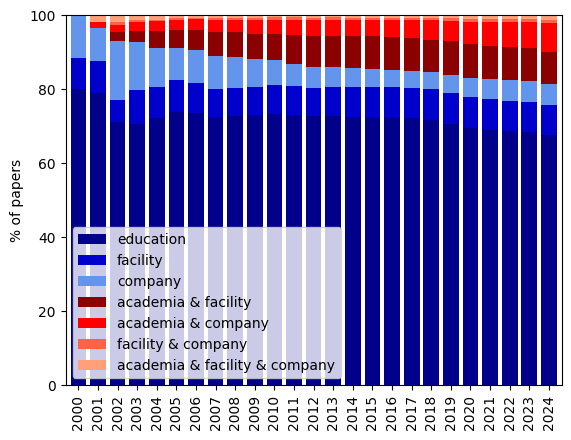

In [4]:
def plot_aff_type(typeDict):
    """
    """
    aff_df = pd.DataFrame.from_dict(typeDict, orient='index')
    my_colors = list(islice(cycle(COLOR_LIST), None, len(aff_df)))
    aff_df.plot(kind='bar', stacked=True, color=my_colors, width=.8)


    plt.ylabel('% of papers')
    plt.legend(['education','facility','company',
                'academia & facility','academia & company',
                'facility & company','academia & facility & company'])

    plt.title('')
    plt.ylim([0,100])
    plt.xticks(np.arange(25), EDITIONS, rotation=90, ha='center')
    plt.show()

plot_aff_type(typeDict)

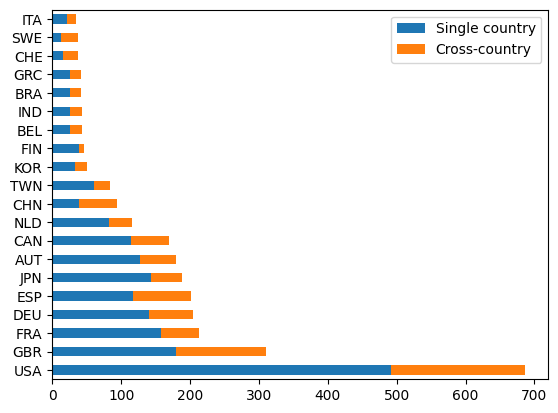

In [5]:
def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))
    
def plot_aff_country():
    """
    """

    aff_df = pd.DataFrame.from_dict(CountryCountDictSorted, orient='index')
    aff_df.plot(kind='barh', stacked=True)

    # plt.ylabel('number of papers')
    plt.legend(['Single country', 'Cross-country'])
    plt.title('')
    plt.ylim([-.5,19.5])
    plt.yticks(np.arange(20), 
                         [key for key, val in take(20,CountryCountDictSorted.items())], 
                         rotation=0)
    plt.show()

plot_aff_country()


Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex


                      country country_code  \
0                   Indonesia          IDN   
1                    Malaysia          MYS   
2                       Chile          CHL   
3                     Bolivia          BOL   
4                        Peru          PER   
..                        ...          ...   
237                     Palau          PLW   
238                      Guam          GUM   
239  Northern Mariana Islands          MNP   
240                   Bahrain          BHR   
241               Macao S.A.R          MAC   

                                              geometry iso2_code Country  \
0    MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...        ID     NaN   
1    MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...        MY     MYS   
2    MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...        CL     NaN   
3    POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...        BO     NaN   
4    MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...        PE   

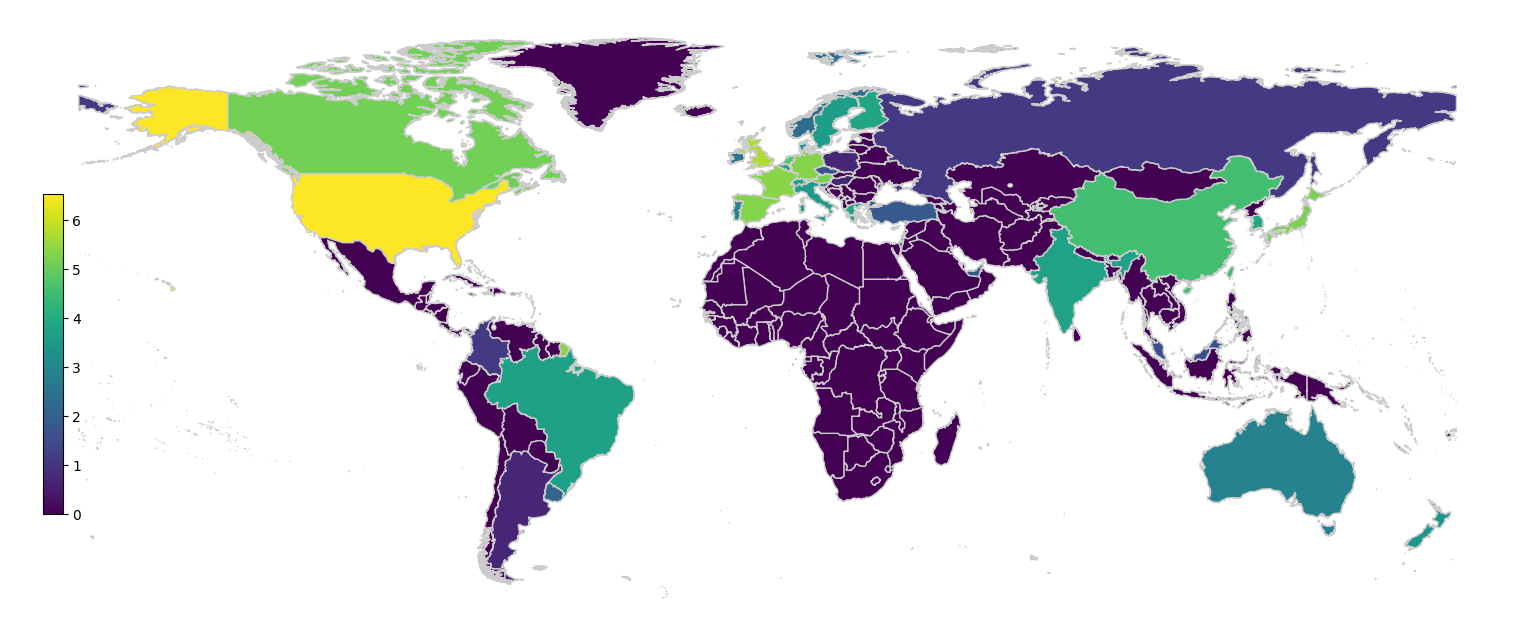

In [6]:
def plot_worldmap():
    """
    """
    # Setting the path to the shapefile
    SHAPEFILE = 'data/worldmap/ne_10m_admin_0_countries.shp'
    # Read shapefile using Geopandas
    geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]
    # Rename columns.
    geo_df.columns = ['country', 'country_code', 'geometry']
    geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)


    iso3_codes = geo_df['country'].to_list()
    # Convert to iso3_codes
    iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
    # Add the list with iso2 codes to the dataframe
    geo_df['iso2_code'] = iso2_codes_list
    # There are some countries for which the converter could not find a country code. 
    # We will drop these countries.
    geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)


    CountryCountDictPlot = {key: val for key, val in temp2 if key!="unknown"}
    country_df = pd.DataFrame(list(CountryCountDictPlot.items()), columns=['Country', 'Value'])

    merged_df = pd.merge(left=geo_df, right=country_df, how='left', left_on='country_code', right_on='Country')

    merged_df["Value"].fillna(1, inplace=True)

    merged_df["Value"] = np.log(merged_df["Value"])
    print(merged_df)

    col = 'Value'
    vmin = merged_df[col].min()
    vmax = merged_df[col].max()
    cmap = 'viridis'
    # Create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(20, 8))
    # Remove the axis
    ax.axis('off')
    merged_df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)

    # Create colorbar as a legend
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
    # Empty array for the data range
    sm._A = []
    # Add the colorbar to the figure
    cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
    cbar = fig.colorbar(sm, cax=cbaxes)

    plt.show()

plot_worldmap()

# Ideas Juan
Following, you can find several ideas of additional analysis that could be shown in the paper. Please, let me know what you think.

In [7]:
all_ismir = df['Affiliation country'].dropna().str.split(',').explode().str.strip().unique().tolist()
all_ismir.remove('unknown')
print(all_ismir)

full_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'XKX', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWZ', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']
print(full_list)

countries = df[df['Year'] == 2001]['Affiliation country'].dropna().str.split(',').explode().str.strip()
country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(all_ismir, fill_value=0)
import numpy as np
array = np.sort(np.array(country_counts))[::-1]
index = np.arange(1, array.shape[0] + 1)
print(array, index)

['JPN', 'USA', 'GBR', 'MYS', 'FRA', 'TWN', 'GRC', 'AUS', 'DEU', 'ESP', 'POL', 'NZL', 'FIN', 'ITA', 'CAN', 'IRL', 'BEL', 'CHN', 'KOR', 'NLD', 'SVN', 'AUT', 'SGP', 'BRA', 'CHE', 'ISR', 'NOR', 'DNK', 'ROU', 'PRT', 'VEN', 'HUN', 'URY', 'SRB', 'HKG', 'IND', 'IRN', 'TUR', 'SWE', 'CYP', 'ARE', 'RUS', 'CZE', 'EST', 'COL', 'UAE', 'ARG', 'VNM']
['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'KHM', 'CMR', 'CAN', 'CPV', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY

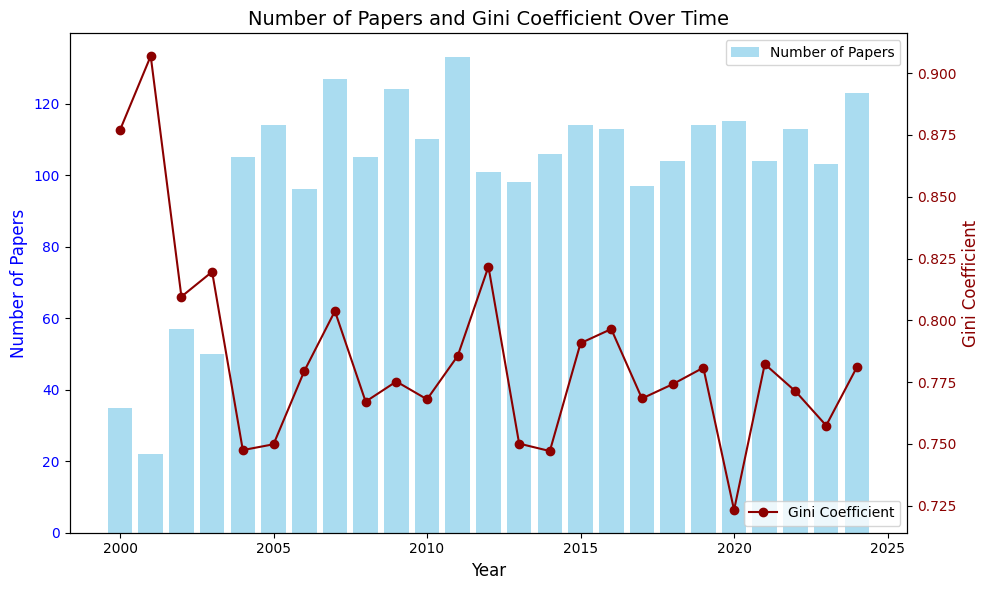

In [8]:
import seaborn as sns
import numpy as np

def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

def gini2(array):
    """Calculate the Gini coefficient of a numpy array, ensuring order invariance."""
    array = np.array(array, dtype=np.float64)
    
    if np.any(array < 0):
        raise ValueError('Negative values!')
    
    if np.sum(array) == 0:
        return 0.0  # If all values are zero, return 0

    array = np.sort(array)  
    cumulative = np.cumsum(array)
    sum_y = cumulative[-1]

    n = array.shape[0]
    gini_coeff = (2 * np.sum((np.arange(1, n + 1) * array)) / sum_y - (n + 1)) / n
    return gini_coeff

def gini3(x, w=None):
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

gini_data = []
for year, group in df.groupby('Year'):
    countries = group['Affiliation country'].dropna().str.split(',').explode().str.strip()
    country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(all_ismir, fill_value=0)
    gini_coeff = gini(country_counts)
    gini_data.append((year, gini_coeff))

gini_df = pd.DataFrame(gini_data, columns=['Year', 'Gini_Coefficient'])
yearly_counts = df['Year'].value_counts().sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Number of Papers and Gini Coefficient Over Time', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(gini_df['Year'], gini_df['Gini_Coefficient'], color='darkred', marker='o', label='Gini Coefficient')
ax2.set_ylabel('Gini Coefficient', fontsize=12, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

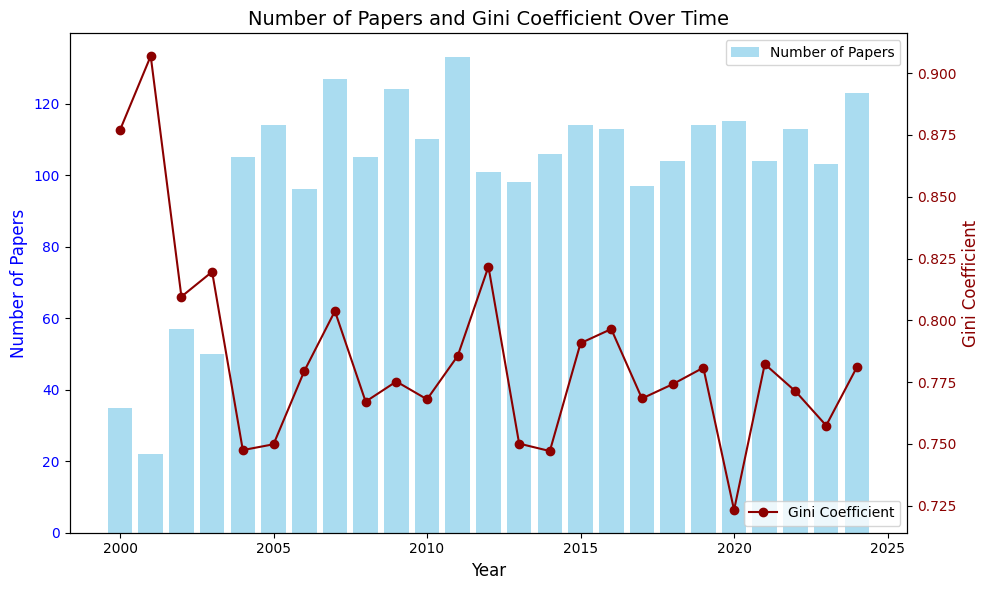

In [9]:
gini_data = []
for year, group in df.groupby('Year'):
    countries = group['Affiliation country'].dropna().str.split(',').explode().str.strip()
    country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(all_ismir, fill_value=0)
    gini_coeff = gini(country_counts)
    gini_data.append((year, gini_coeff))

gini_df = pd.DataFrame(gini_data, columns=['Year', 'Gini_Coefficient'])
yearly_counts = df['Year'].value_counts().sort_index()

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Number of Papers and Gini Coefficient Over Time', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(gini_df['Year'], gini_df['Gini_Coefficient'], color='darkred', marker='o', label='Gini Coefficient')
ax2.set_ylabel('Gini Coefficient', fontsize=12, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

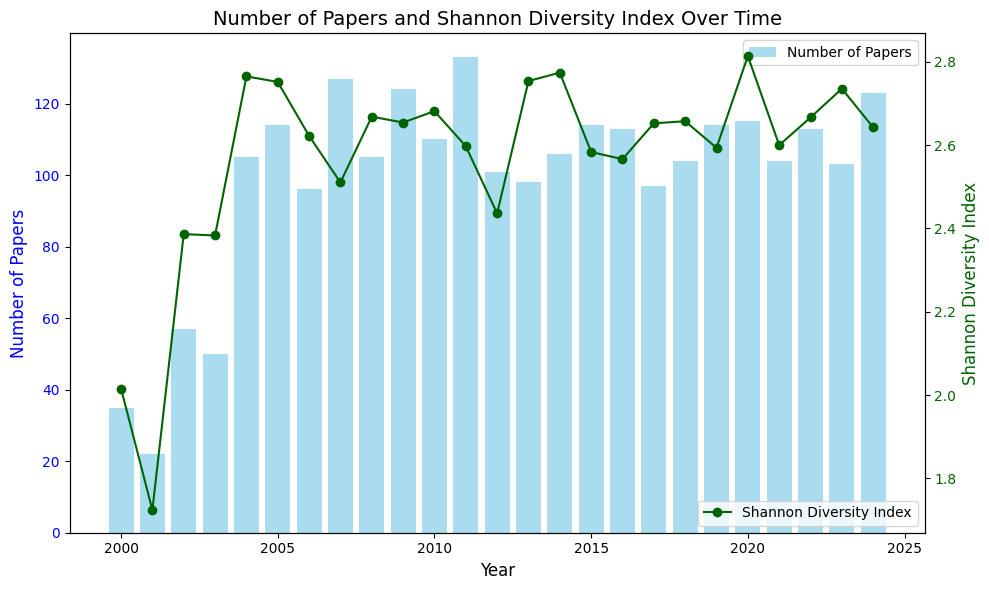

In [10]:
def shannon_diversity(proportions):
    """Calculate Shannon Diversity Index."""
    proportions = np.array(proportions, dtype=np.float64)
    proportions = proportions[proportions > 0]
    return -np.sum(proportions * np.log(proportions))

shannon_data = []
for year, group in df.groupby('Year'):
    countries = group['Affiliation country'].dropna().str.split(',').explode().str.strip()
    country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(full_list, fill_value=0)
    total_affiliations = country_counts.sum()
    proportions = country_counts / total_affiliations
    h_index = shannon_diversity(proportions)
    shannon_data.append((year, h_index))

shannon_df = pd.DataFrame(shannon_data, columns=['Year', 'Shannon_Diversity_Index'])

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Number of Papers and Shannon Diversity Index Over Time', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(shannon_df['Year'], shannon_df['Shannon_Diversity_Index'], color='darkgreen', marker='o', label='Shannon Diversity Index')
ax2.set_ylabel('Shannon Diversity Index', fontsize=12, color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

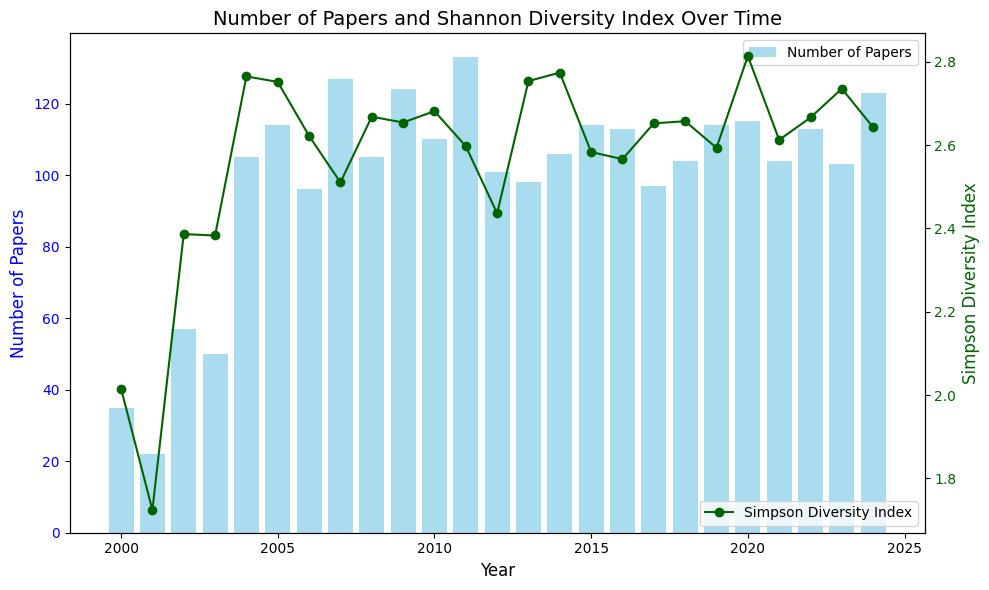

In [11]:
from scipy.stats import entropy


shannon_data = []
for year, group in df.groupby('Year'):
    countries = group['Affiliation country'].dropna().str.split(',').explode().str.strip()
    country_counts = countries.value_counts().drop('unknown', errors='ignore').reindex(all_ismir, fill_value=0)
    shannon_ent = entropy(country_counts)
    shannon_data.append((year, shannon_ent))

shannon_df = pd.DataFrame(shannon_data, columns=['Year', 'Shannon_Diversity_Index'])

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Number of Papers and Shannon Diversity Index Over Time', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(shannon_df['Year'], shannon_df['Shannon_Diversity_Index'], color='darkgreen', marker='o', label='Simpson Diversity Index')
ax2.set_ylabel('Simpson Diversity Index', fontsize=12, color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')

ax1.legend(loc='upper right')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

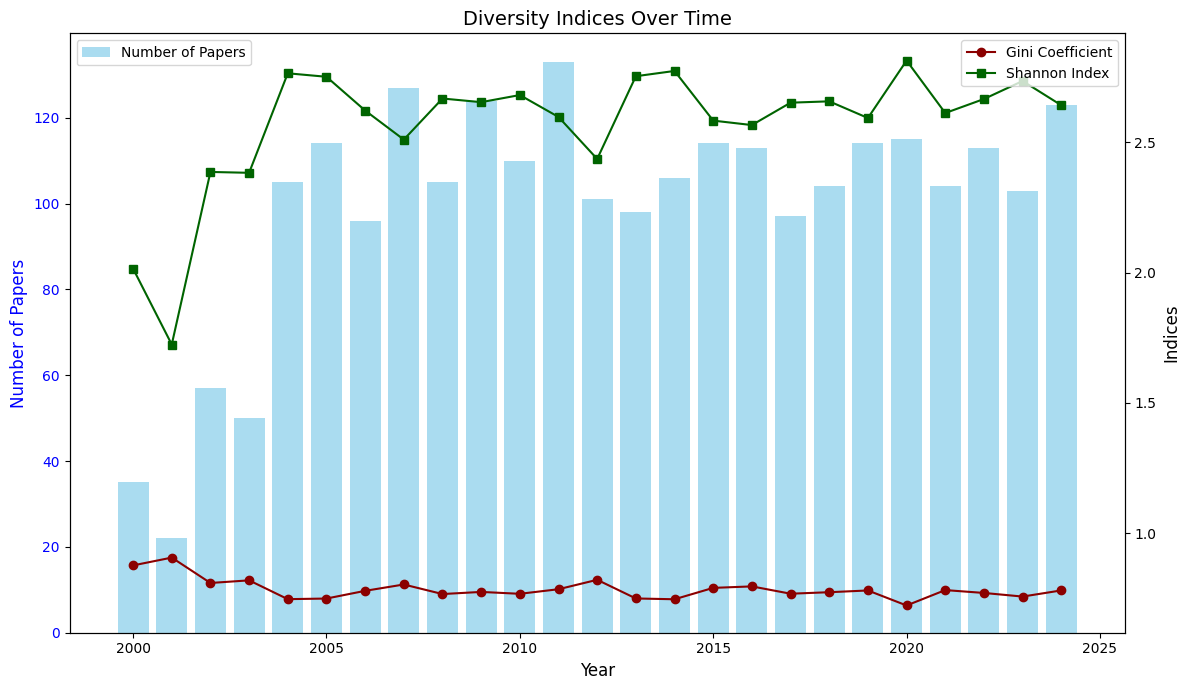

In [12]:
combined_df = pd.merge(gini_df, shannon_df, on='Year', how='inner')
fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.bar(yearly_counts.index, yearly_counts.values, color='skyblue', alpha=0.7, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Papers', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Diversity Indices Over Time', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(combined_df['Year'], combined_df['Gini_Coefficient'], 
         color='darkred', marker='o', label='Gini Coefficient')
ax2.plot(combined_df['Year'], combined_df['Shannon_Diversity_Index'], 
         color='darkgreen', marker='s', label='Shannon Index')
ax2.set_ylabel('Indices', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

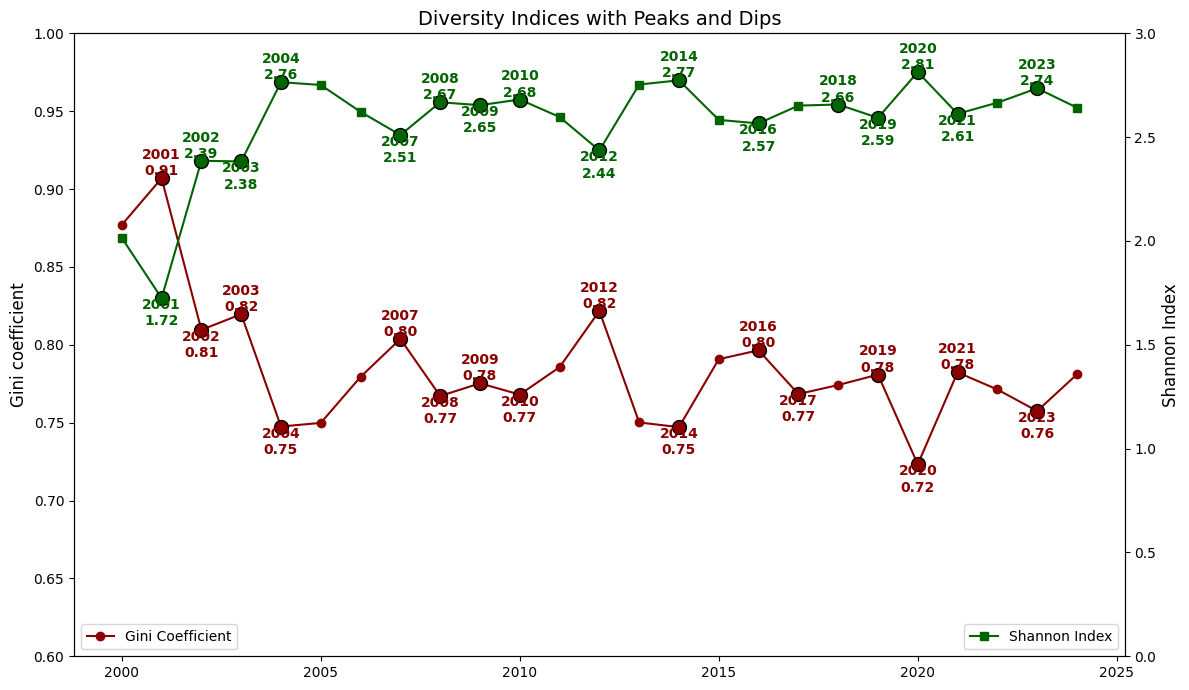

In [13]:
import scipy.signal

def find_extrema(series):
    maxima = scipy.signal.argrelextrema(series.values, np.greater)[0]  # Peaks
    minima = scipy.signal.argrelextrema(series.values, np.less)[0]  # Dips
    return series.iloc[maxima], series.iloc[minima]

gini_peaks, gini_dips = find_extrema(combined_df.set_index('Year')['Gini_Coefficient'])
shannon_peaks, shannon_dips = find_extrema(combined_df.set_index('Year')['Shannon_Diversity_Index'])


fig, ax1 = plt.subplots(figsize=(12, 7))

ax1.plot(combined_df['Year'], combined_df['Gini_Coefficient'], 
         color='darkred', marker='o', label='Gini Coefficient')
ax1.set_title('Diversity Indices with Peaks and Dips', fontsize=14)
for series, color, label in [(gini_peaks, 'darkred', 'Gini Peak'), 
                              (gini_dips, 'darkred', 'Gini Dip')]:
    for year, value in series.items():
        ax1.scatter(year, value, color=color, s=100, edgecolors='black', zorder=3)  # Highlight points
        ax1.text(year, value, f"{year}\n{value:.2f}", fontsize=10, 
                 ha='center', va='bottom' if 'Peak' in label else 'top', 
                 color=color, fontweight='bold')
ax1.set_ylabel('Gini coefficient', fontsize=12, color='black')
ax1.set_ylim([0.6, 1])


ax2 = ax1.twinx()
ax2.plot(combined_df['Year'], combined_df['Shannon_Diversity_Index'], 
         color='darkgreen', marker='s', label='Shannon Index')

for series, color, label in [(shannon_peaks, 'darkgreen', 'Shannon Peak'), 
                              (shannon_dips, 'darkgreen', 'Shannon Dip')]:
    for year, value in series.items():
        ax2.scatter(year, value, color=color, s=100, edgecolors='black', zorder=3)  # Highlight points
        ax2.text(year, value, f"{year}\n{value:.2f}", fontsize=10, 
                 ha='center', va='bottom' if 'Peak' in label else 'top', 
                 color=color, fontweight='bold')

ax2.set_ylabel('Shannon Index', fontsize=12, color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim([0, 3])

ax1.legend(loc='lower left')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Interpretation:

A dip in Shannon and a peak in Gini suggests increasing concentration / decreasing diversity.
- 2001, 2003, *2007*, 2009, *2012*, *2019*

A peak in Shannon and a dip in Gini suggests decreasing concentration / increasing diversity.
- 2002, 2004, *2014*, *2020*

Are there historical moments here other than covid?


# Network analysis
Analyze the co-authorship or affiliation networks for geographic and institutional diversity.

I tried variations of this but tbh, I'm not sure that it is very readable (or understandable), but maybe someone else can give it shot?


In [21]:
import networkx as nx
from pyvis.network import Network

edges = []
for _, row in df.iterrows():
    authors = row['Authors'].split(';')  # Split authors
    countries = row['Affiliation country'].split(',')  # Split country codes
    for author, country in zip(authors, countries):
        edges.append((author.strip(), country.strip()))  # Add edges between authors and countries

# Step 2: Create a bipartite graph
B = nx.Graph()
B.add_edges_from(edges)

# Step 3: Separate Authors and Countries
authors = {node for node, degree in B.degree if any(node in edge for edge in edges)}
countries = set(B) - authors

# Step 4: Compute centrality and node sizes
degree_centrality = nx.degree_centrality(B)
node_size = {node: degree_centrality[node] * 50 for node in B.nodes}  # Scale size for Pyvis
country_size = {node: degree_centrality[node] * 100 for node in countries}  # Larger size for countries

# Step 5: Create Pyvis Network with Stabilization and Fixed Physics
net = Network(notebook=True, height="800px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='in_line')

# Stabilization and physics control
net.force_atlas_2based(gravity=-1000, central_gravity=0.01, spring_length=100, spring_strength=0.01, damping=0.1)  # Customize physics for stability

# Step 6: Add Nodes
for node in B.nodes:
    color = "lightblue" if node in authors else "darkblue"  # Change color for better contrast on dark background
    size = node_size.get(node, 5) + 5  # Ensure minimum size for authors
    if node in countries:
        size = country_size.get(node, 100) + 30  # Make country nodes larger
        color = "lightgreen"  # Change country color for contrast

    net.add_node(
        node, 
        label=node, 
        size=size, 
        color=color,
        title=f"Node: {node}"  # Hover tooltip with node name
    )


# Step 7: Add Edges
for edge in B.edges:
    net.add_edge(*edge, color="lightblue", width=0.5)

# Step 8: Show the Network directly in Jupyter
net.show("author_country_network.html")

author_country_network.html


# Wordclouds

To be a bit more specific, perhaps this could be related more to general topics as discussed by Herrera PhD Thesis:
- 2000-2004: age of feature extractors
- 2004-2009: age of semantic content
- 2009-2014: age of context-aware systems
- 2014-today: age of creative systems

To be fair, he said that the ages keep on going to right now. But it's seems that the word clouds work... ?

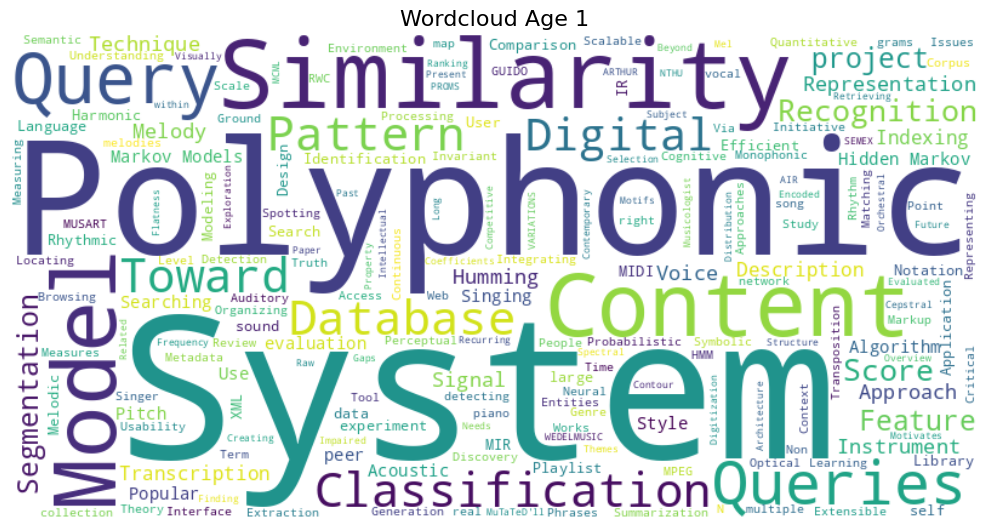

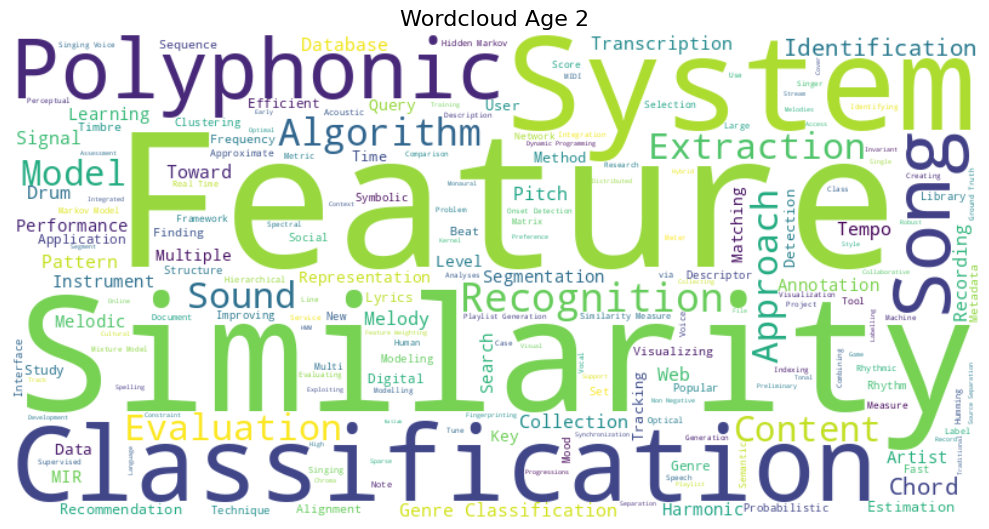

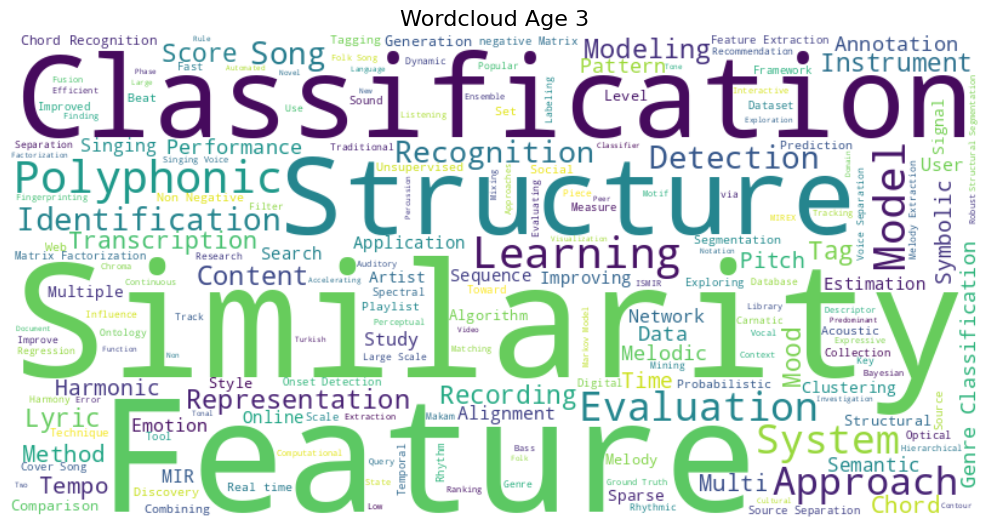

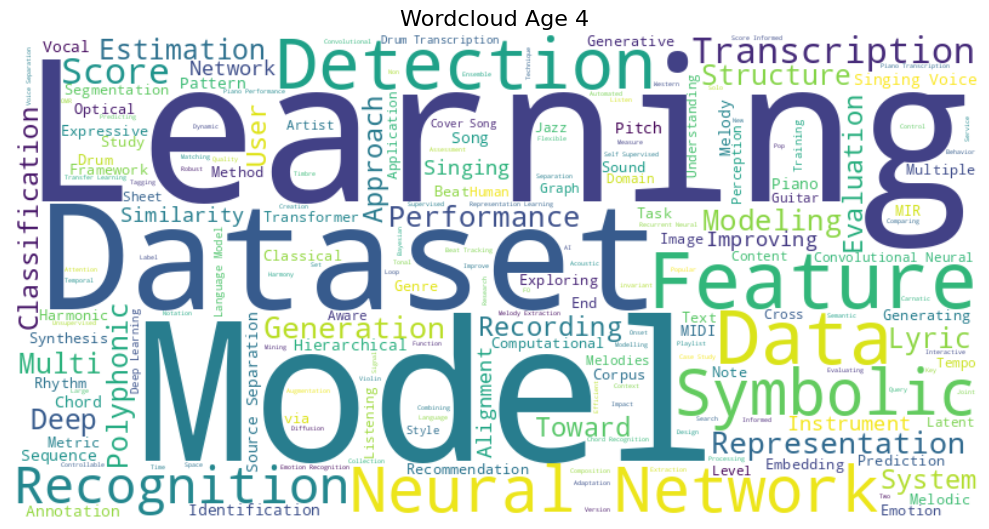

In [31]:
from wordcloud import WordCloud, STOPWORDS

custom_stopwords = set(['music', 'audio', 'using', 'musical', 'retrieval', 'analysis', 'based', 'automatic', 'information'])
stopwords = STOPWORDS.union(custom_stopwords)

df_1 = df[(df['Year'] >= 2000) & (df['Year'] < 2004)]
df_2 = df[(df['Year'] >= 2004) & (df['Year'] < 2009)]
df_3 = df[(df['Year'] >= 2009) & (df['Year'] < 2014)]
df_4 = df[(df['Year'] >= 2014) & (df['Year'] < 2025)]

text_ttl_1 = ' '.join(df_1['Title'].dropna().tolist())
text_ttl_2 = ' '.join(df_2['Title'].dropna().tolist())
text_ttl_3 = ' '.join(df_3['Title'].dropna().tolist())
text_ttl_4 = ' '.join(df_4['Title'].dropna().tolist())

wordcloud_ttl_1 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_ttl_1)
wordcloud_ttl_2 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_ttl_2)
wordcloud_ttl_3 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_ttl_3)
wordcloud_ttl_4 = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_ttl_4)


plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ttl_1, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Age 1', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ttl_2, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Age 2', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ttl_3, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Age 3', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_ttl_4, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Age 4', fontsize=16)
plt.tight_layout()
plt.show()